In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft
import os
import pandas as pd

frame_size = 500 # millisecond
hopping = 1 # 100% hopping, 0 overlapping. for feature extraction

In [90]:
# Importing the audiofile
home_dir = '..'
audio_dir = os.path.join(home_dir, 'audio')
filename = "recording.wav"
filename_text = filename.rsplit('.', 1)[0].lower()
# convert file if not .wav
if filename[-3:] == "mp3":
        wav_audio = AudioSegment.from_mp3(filename)
        audio_path = filename[:-3:] + "wav" # set new audio_path
        wav_audio.export(filename, format="wav")

from pydub import AudioSegment
sound = AudioSegment.from_file(os.path.join(audio_dir, filename)) #, format='wav')
sound = sound.split_to_mono()[0]
#Getting sample rate and samples
sample_rate = sound.frame_rate
duration = sound.duration_seconds
samples = np.divide(sound.get_array_of_samples(), sound.max_possible_amplitude)
print(sample_rate, len(samples))

48000 558720


In [98]:
frame_size_sample = frame_size * sample_rate * 1e-3
hop_size_sample = hopping*frame_size_sample
num_frames = int(np.ceil((len(samples)-frame_size_sample)/hop_size_sample) + 1) # use this format to calculate num frames

print((len(samples)-frame_size_sample)//frame_size_sample + 1)
print(duration, num_frames)

23.0
11.64 24


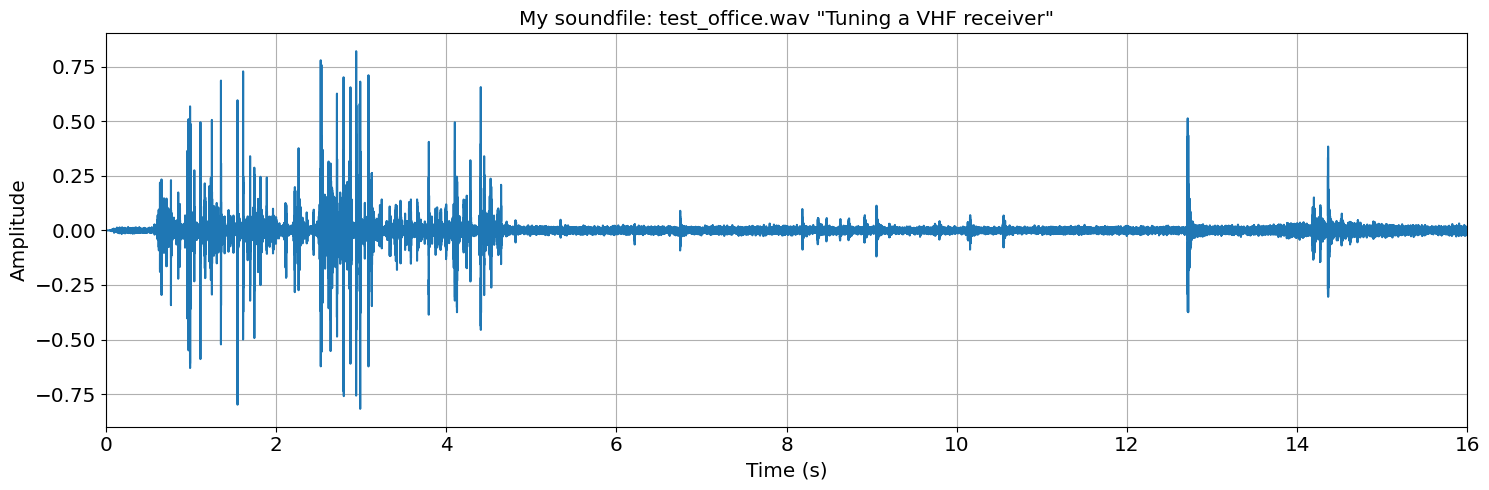

In [77]:
# The following makes the plot look nice
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig, ax = plt.subplots()
plt.plot(np.arange(len(samples))/sample_rate, samples)
ax.set_title('My soundfile: test_office.wav "Tuning a VHF receiver"')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time (s)')
ax.set_xlim(left=0,right=duration)
fig.tight_layout()
plt.grid()

3. Write a function that will take in the samples of an audio file, a frame size in samples, a hop size in samples, and a sampling rate, and compute and return the spectral centroid of each frame. The spectral centroid of a rectangular window of audio $x[n]$ of length $N$ (even) is defined as 
$$ R_{0.5}(x) = \frac{\sum_{k=0}^{N/2+1} \frac{F_s k}{N} |X[k]|}{\sum_{k=0}^{N/2+1} |X[k]|} $$
where $X[k]$ is the DFT of $x[n]$, and $F_s$ is the sampling rate.

In [101]:
# add your code below
def extractSpectralCentroid(samples, sample_rate, frame_size, hop_size):
    # import math
    frame_size = int(frame_size*sample_rate*1e-3) #convert from ms to number of samples
    hop_size = int(hop_size*frame_size) #hop size into number of samples
    frame_number = int(np.ceil((len(samples)-frame_size_sample)/hop_size_sample) + 1) #number of frames
    spectral_centroids = []
    
    for i in range(frame_number):
        current_frame = samples[i*hop_size: i*hop_size+frame_size]
        N = len(current_frame)
        fft_frame = np.abs(fft(current_frame))[0:((N//2)+1)]
        numerator_factors = []
        for k in range(len(fft_frame)):
            numerator_factors.append((sample_rate*k*fft_frame[k])//N)
            
        numerator = np.sum(numerator_factors)
        denominator = np.sum(fft_frame)
        
        spectral_centroids.append(numerator//denominator)
        

    return spectral_centroids

4. Using your function, compute spectral centroid features for contiguous 46 ms frames hopped 50% for the audio file you used in part 1. (Ignore any frames at the end of audio files that are less than that length.) Plot the first 10 seconds of your time domain waveform, and plot the series of spectral centroids you extracted.

(0.0, 10.0)

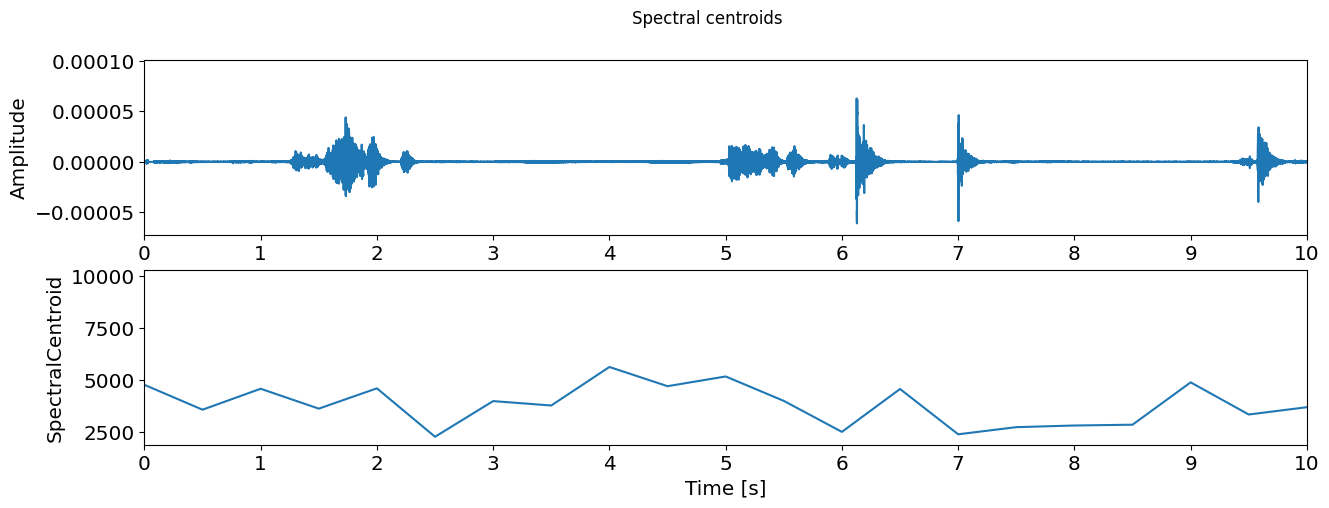

In [102]:
# add your code below
spectral_centroids = extractSpectralCentroid(samples, sample_rate, frame_size, hopping)

fig_, ax = plt.subplots(2)
fig_.suptitle('Spectral centroids')

# subplot: waveform
y = [samples[i]/10000.0 for i in range(len(samples))]
xticks = [sample_rate*i for i in range(11)]
ax[0].plot(y)
# ax[0].set_title('Time domain waveform in 10 seconds')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Amplitude')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([i for i in range(11)])
ax[0].set_xlim([0, 10*sample_rate])
# subplot: spectral centroids with framing
time = [ round( 1e-3* i* hopping*frame_size, 3 ) for i in range(len(spectral_centroids)) ]
ax[1].plot(time, spectral_centroids)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('SpectralCentroid')
ax[1].set_xticks([i for i in range(11)])
ax[1].set_xlim([0, 10])

In [103]:
def RMS(samples, sample_rate, frame_size, hop_size):
    # import math
    frame_size = int(frame_size*sample_rate*1e-3) #convert from ms to number of samples
    hop_size = int(hop_size*frame_size) #hop size into number of samples
    frame_number = int(np.ceil((len(samples)-frame_size_sample)/hop_size_sample) + 1) #number of frames
    rms = []

    for i in range(frame_number):
        current_frame = samples[i*hop_size: i*hop_size+frame_size]
        rms.append(np.sqrt(np.mean(current_frame**2)))
    
    return rms

(0.0, 10.0)

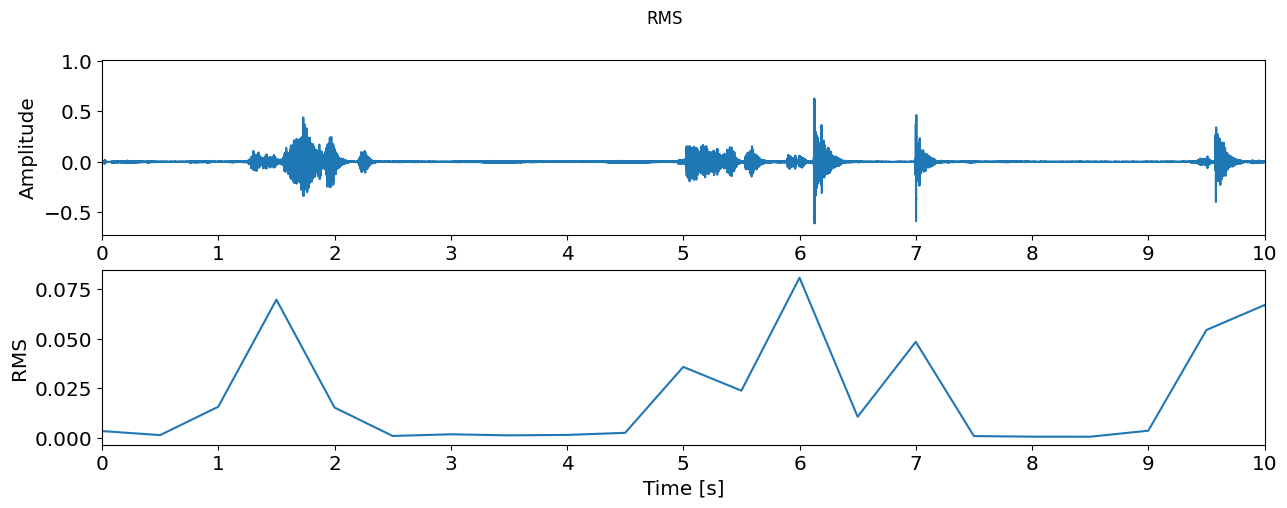

In [104]:
rms = RMS(samples, sample_rate, frame_size, hopping)

fig_, ax = plt.subplots(2)
fig_.suptitle('RMS')
# subplot: waveform
y = [samples[i] for i in range(len(samples))]
xticks = [sample_rate*i for i in range(11)]
ax[0].plot(y)
# ax[0].set_title('Time domain waveform in 10 seconds')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Amplitude')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([i for i in range(11)])
ax[0].set_xlim([0, 10*sample_rate])
# subplot: spectral centroids with framing
time = [ round( 1e-3* i* hopping*frame_size, 3 ) for i in range(len(rms)) ]
ax[1].plot(time, rms)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('RMS')
ax[1].set_xticks([i for i in range(11)])
ax[1].set_xlim([0, 10])

In [105]:
def normalizeFeature(x):
    x = np.asarray(x)
    x = np.divide(x, np.absolute(x).max())
    return x.tolist()

In [106]:
spectral_centroids = normalizeFeature(spectral_centroids)
rms = normalizeFeature(rms)

In [107]:
# [filename, chunk number (file sub index), start time, end time, spec centroid, rms]

# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
# UPLOAD_FOLDER = os.path.join(BASE_DIR, 'uploads')
# data_dir = os.path.join(BASE_DIR, 'data')

filename_text = filename.rsplit('.', 1)[0].lower()
filename_extension = filename.rsplit('.', 1)[1].lower()

data_dir = os.path.join('../data', filename_text)
data_file = 'data.csv'
data_file = os.path.join(data_dir, data_file)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
print(data_file)

../data/recording/data.csv


In [94]:
print(len(spectral_centroids))
print(spectral_centroids[23])

32
0.751453488372093


In [99]:
def save_to_csv(df, file_name, header=True):
    # Check if the file already exists
    if os.path.isfile(file_name):
        # If it exists, append without writing the header
        df.to_csv(file_name, mode='a', header=False, index=False)
    else:
        # If it does not exist, create the file with the header
        df.to_csv(file_name, mode='w', header=header, index=False)

In [100]:
data = []
# for the same audio file
for i in range(num_frames):
    data.append([filename, i, i*frame_size*1e-3, (i+1)*frame_size*1e-3, spectral_centroids[i], rms[i]])
    # print(i, data[i])

df = pd.DataFrame(data, columns = ['filename', 'chunk index', 'start time sec', 'end time sec', 'centroid', 'rms'])
print(df[-3:])

save_to_csv(df, data_file)

         filename  chunk index  start time sec  end time sec  centroid  \
21  recording.wav           21            10.5          11.0  0.537064   
22  recording.wav           22            11.0          11.5  0.728561   
23  recording.wav           23            11.5          12.0  0.751453   

         rms  
21  0.121189  
22  0.096984  
23  0.092347  


In [18]:
import pandas as pd
filename = '../data/test_office/data.csv'
data = pd.read_csv(filename, header=0)
feed_data = data.values.tolist()
print(type([1,2,3]))
print(type(feed_data))
print(feed_data[0], '\n', len(feed_data))

<class 'list'>
<class 'list'>
['test_office.wav', 0, 0.0, 0.5, 0.5050872093023255, 0.0707144135259617] 
 64
